### Autoencoders

Definición: https://www.ibm.com/es-es/topics/autoencoder 

Tipos:[ \[link\]](https://deeplearningofpython.blogspot.com/2023/05/Typesofautoencoders-implementation-keras.html?source=post_page-----383cfecc4d0e--------------------------------)

Como funcionan: https://www.geeksforgeeks.org/how-autoencoders-works/ 

Compresión de imágenes y regeneración de imágenes

- latent space: https://www.geeksforgeeks.org/what-is-latent-space-in-deep-learning/ 

- Reconstrucción imágenes a partir del espacio latente https://medium.com/@jaiganesan/autoencoder-is-simple-9055a7b5b935 

- Calidad de reconstrucción y pérdida de información: https://medium.com/@bhipanshudhupar/loss-functions-in-simple-autoencoders-mse-vs-l1-loss-4e838ae425b9 

In [113]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.models import vgg19_bn
from torch.optim import Adam
from torchmetrics.functional.regression import mean_squared_error


import matplotlib.pyplot as plt
import wandb
import numpy as np
import pylab as pl
import random
from IPython import display
from tqdm import tqdm


In [114]:
wandb.init(
    # set the wandb project where this run will be logged
    project="autoencoder",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "VGG19",
    "dataset": "CIFAR-10",
    "epochs": 100,
    }
)

In [115]:
TRAINING_SIZE=15
TEST_SIZE=10

### Load Cifar10

In [116]:
training_set = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_set = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

In [117]:
print(len(training_set))
print(len(test_set))

50000
10000


In [118]:
print(training_set[0][0].shape)

torch.Size([3, 224, 224])


Normalization?

In [119]:
train_dl = DataLoader(Subset(training_set, range(10000)), batch_size=TRAINING_SIZE,shuffle=True, num_workers=2)
test_dl = DataLoader(Subset(test_set, range(4000)), batch_size=TEST_SIZE,shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


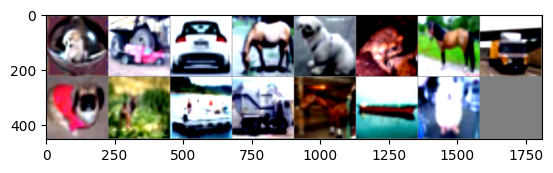

In [120]:
images, labels = next(iter(train_dl))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5); 

### Model Architecture

#### Encoder

In [121]:
encoder = vgg19_bn(weights=None, progress=True)
encoder = encoder.features[:39]
print(encoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

#### Model

In [122]:
class AutoEncoder(torch.nn.Module):
	def __init__(self, encoder):
		super().__init__()
	
		self.encoder = encoder
		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True),

      
	    nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True),

      
      
	    nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True),

	    nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


# Training and evaluation

In [123]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(33)

In [124]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [125]:
def traintestpipeline(epochs: int, optim: Adam, criterion: nn.MSELoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for (input_img, target) in tqdm(train_dl):
            input_img = input_img.to(device).float()
            # forward pass
            output = model(input_img)

            loss = criterion(output,input_img)
            t_acc = mean_squared_error(output, input_img)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()   
                                                        
        model.eval()   
        with torch.no_grad():                                          
             for (input_img, target) in tqdm(test_dl):
                input_img = input_img.to(device).float()
                # forward pass
                output = model(input_img)
   
                loss = criterion(output, input_img)   
                v_acc = mean_squared_error(output, input_img)
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(test_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        
        wandb.log({"acc": t_acc, "Trainingloss": train_loss})
        wandb.log({"acc": v_acc, "Validationloss": val_loss})
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")
    wandb.finish()

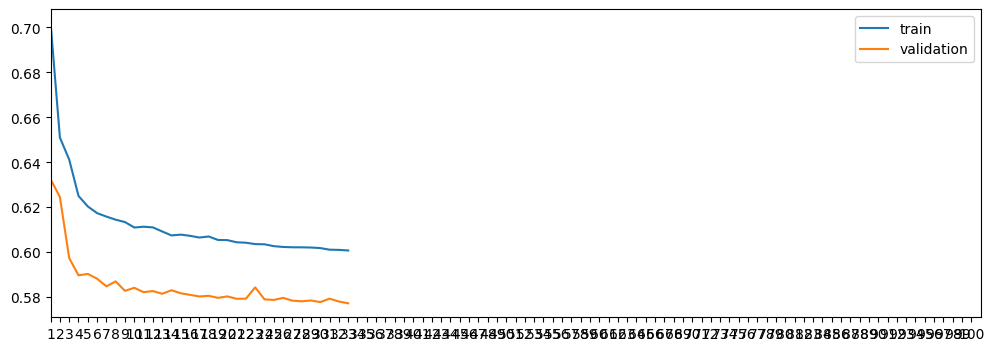

 90%|█████████ | 602/667 [00:56<00:06, 10.74it/s]ion Loss:0.5772834840416908:  33%|███▎      | 33/100 [40:20<1:21:59, 73.42s/it]
Epoch:33 Training Loss:0.6007764028019454 Validation Loss:0.5772834840416908:  33%|███▎      | 33/100 [41:16<1:23:48, 75.05s/it]


KeyboardInterrupt: 

In [126]:
traintestpipeline(100,optimizer, loss, 10000, "autoencoder.pt")

In [127]:
def showImages(test_dl, model):
    with torch.no_grad():
        model.eval()
        for data, _ in test_dl:  # Get one batch from the test DataLoader
                data = data.to(device).float()
                output = model(data)
                fig, ax = plt.subplots(1, 2, figsize=(8,4))
                ax[0].imshow(data[0].cpu().permute(1, 2, 0).numpy(), cmap='gray')
                ax[1].imshow(output[0].cpu().permute(1, 2, 0).numpy(), cmap='gray')
                ax[0].set_title("Origina Image")
                ax[1].set_title("Reconstructed Image")
                plt.show()
                break 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6855742..2.64].


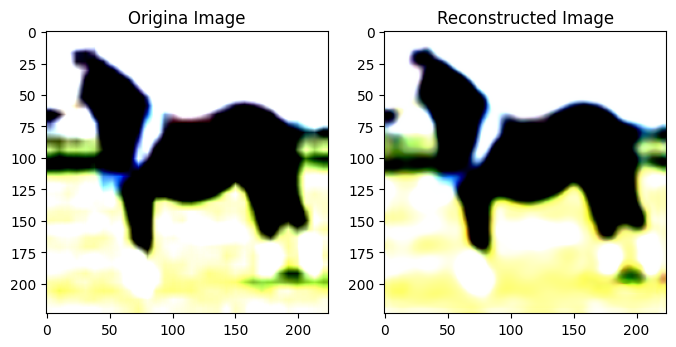

In [128]:
showImages(test_dl, model)